# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import time
import re

from sklearn.svm import SVC as svc 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

!pip show seaborn

import matplotlib.pyplot as plt
import seaborn as sns


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Name: seaborn
Version: 0.8.1
Summary: Seaborn: statistical data visualization
Home-page: http://seaborn.pydata.org
Author: Michael Waskom
Author-email: mwaskom@nyu.edu
License: BSD (3-clause)
Location: /opt/conda/lib/python3.6/site-packages
Requires: numpy, scipy, matplotlib, pandas
Required-by: 


# Analysis

## Data Exploration and Visualization

### 1.Portfolio Dataset

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.shape

(10, 6)

There are ten rows and six columns in the portfolio dataset. It seems that it is a simple dataset.

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


**'channels', 'id', 'offer_type columns'** are categorical items whereas **'difficulty', 'duration', 'reward'** are integer

In [5]:
# Rename id column to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [6]:
# Check for the null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
offer_id      0
offer_type    0
reward        0
dtype: int64

In [7]:
# checking for duplicates
portfolio.columns.duplicated().sum()

0

There is no missing/null or duplicate value in the portfolio dataset

Now we can handle the categorical data, lets start with **channel** column.

In [8]:
portfolio.channels.apply(pd.Series).stack().unique()

array(['email', 'mobile', 'social', 'web'], dtype=object)

The **channels** column consist of a list contaning the channels, **(email, mobile, social, web)**, that the offers are communicated. So, I will be expanding this categorical column.

In [9]:
dummy_channels =  pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, dummy_channels], axis=1)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


Let's continue with encoding **offer_type** 

In [10]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [11]:
# clean offer types
offer_types = pd.get_dummies(portfolio.offer_type)
portfolio = pd.concat([portfolio, offer_types], axis=1)
portfolio.head(15)


,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


#### 1.2.Highligths and Observations
**portfolio dataset** is a simple dataset with 10 rows, 6 columns & no missing and duplicate values. **channels**, **offer_types** categorical values are encoded and values are stored in new columns for later use as shown above.

There are three types of offers : 'bogo'(Buy One Get One free), 'informational' and 'discount'.
There are 4 offers included in the dataset that are classified as : “bogo“ , 4 offers classified as : ”discount” and 2 offers classified as : “informational”.

The 'difficulty' is minimum required spend to complete an offer. Rescaling this feature is a useful step to do. This needs to be done before Modeling.

In [12]:
# Save the prosessed portfolio dataset
portfolio.to_csv('data/portfolio.csv', index = False)

### 2.Profile Dataset
Demographic data for customers is provided in the **profile** dataset. The schema and variables are as follows:

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

#### 2.1.Data Exploration (Profile)

In [13]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
profile.shape

(17000, 5)

There are 17000 rows and 5 cloumns in the dataset.

In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


**id** and **gender** have object data type whereas **age, became_member_on** and **income** columns are numerical. We may need to handle the **become_member_on** and **gender**.

In [16]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There are 2175 null items both in **gender** and **income** columns. Lets check whether or not they belong to the same row.

In [17]:
profile[profile.gender.isnull()][['gender','age','income']].head(10)


,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


It seems that **gender** and **income** is null at the same time for all the 2175 rows. Age value is also 118 on these rows. 

Let's remove 2175 rows with null values.

In [18]:
profile = profile.dropna(how='any',axis=0)

In [19]:
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [20]:
profile.duplicated().sum()

0

There is no duplicate rows and null values in the dataset.

In [38]:
# Rename id column to customer_id (unification with person column in Transcript dataset)
profile.rename(columns={'id': 'customer_id'}, inplace=True)

Let's transform the **gender** column:

In [21]:
profile = pd.concat([profile, pd.get_dummies(profile['gender'], prefix='gender')], axis=1)

In [22]:
profile.head()

,age,became_member_on,gender,id,income,gender_F,gender_M,gender_O
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


Let's transform the **age** column:

In [26]:
# changing the datatype of 'age' and 'income' columns to 'int'
profile[['age','income']] = profile[['age','income']].astype(int)

In [27]:
# creating a new column representing the age group to which the customer belongs 
profile['age_group'] = pd.cut(profile['age'], bins=[17, 25, 40, 60, 110],labels=['teenager', 'young-adult', 'adult', 'elderly'])

In [28]:
# checking the unique values in the newely created column
profile['age_group'].head()

1       adult
3     elderly
5     elderly
8     elderly
12      adult
Name: age_group, dtype: category
Categories (4, object): [teenager < young-adult < adult < elderly]

In [29]:
# replacing the 'age_group' categorical labels by numerical labels
labels_age_group = profile['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}

# replace categorical labels in 'age_group' column with numerical labels
profile.replace(replace_map_comp_age_group, inplace=True)

# confirming that the replacement has been correctly performed 
profile['age_group'].head()

1     3
3     4
5     4
8     4
12    3
Name: age_group, dtype: int64

Let's transform the **income** column:

In [31]:
# creating a new column representing the age group to which the customer belongs 
profile['income_range'] = pd.cut(profile['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])

# replacing the 'income_range' categorical labels by numerical labels
labels_income_range = profile['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range = {'income_range' : {k: v for k,v in zip(labels_income_range,list(range(1,len(labels_income_range)+1)))}}

# replacing categorical labels in 'income_range' column with numerical labels
profile.replace(replace_map_comp_income_range, inplace=True)
profile.head()

,age,became_member_on,gender,id,income,gender_F,gender_M,gender_O,age_group,income_range
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1,0,0,4,3
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000,0,1,0,4,2
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000,0,1,0,4,1
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000,0,1,0,3,1


Let's transform the **became_member_on** column from string to date

In [32]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [33]:
profile['year_joined'] = profile['became_member_on'].dt.year

# adding a new column 'membership_days' ,that will present the number of days since the customer become a member
profile['membership_days'] = pd.datetime.today().date() - profile['became_member_on'].dt.date

# removing the 'days' unit
profile['membership_days'] = profile['membership_days'].dt.days
profile['membership_days'] = profile['membership_days'] - 1500
profile.head()

,age,became_member_on,gender,id,income,gender_F,gender_M,gender_O,age_group,income_range,year_joined,membership_days
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,2017,642
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1,0,0,4,3,2017,709
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000,0,1,0,4,2,2018,357
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000,0,1,0,4,1,2018,433
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000,0,1,0,3,1,2017,523


Let's transform the **membership_days**:

In [34]:
# creating a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'
profile['member_type'] = pd.cut(profile['membership_days'], bins=[190, 750, 1600, 42500],labels=['new', 'regular', 'loyal'])

# replacing the 'member_type' categorical labels by numerical labels
labels_member_type = profile['member_type'].astype('category').cat.categories.tolist()
replace_map_comp_member_type = {'member_type' : {k: v for k,v in zip(labels_member_type,list(range(1,len(labels_member_type)+1)))}}

# replacing categorical labels in 'member_type' column with numerical labels
profile.replace(replace_map_comp_member_type, inplace=True)

profile.head()
print(replace_map_comp_member_type)

{'member_type': {'new': 1, 'regular': 2, 'loyal': 3}}


In [35]:
profile.membership_days.describe()

count    14825.000000
mean       788.478988
std        419.205158
min        266.000000
25%        474.000000
50%        624.000000
75%       1063.000000
max       2089.000000
Name: membership_days, dtype: float64

In [36]:
profile.member_type.value_counts()

1    10602
2     3335
3      888
Name: member_type, dtype: int64

In [48]:
profile.head()

,age,became_member_on,gender,customer_id,income,gender_F,gender_M,gender_O,age_group,income_range,year_joined,membership_days,member_type
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,2017,642,1
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1,0,0,4,3,2017,709,1
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000,0,1,0,4,2,2018,357,1
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000,0,1,0,4,1,2018,433,1
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000,0,1,0,3,1,2017,523,1


In [37]:
profile.shape

(14825, 13)

In [56]:
profile.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34a3462c88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f34a25eb1d0>]], dtype=object)

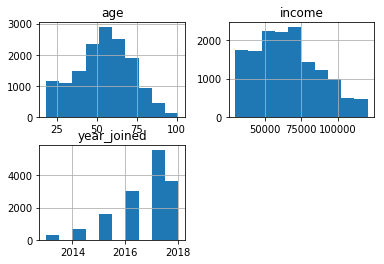

In [60]:
profile[['age', 'income', 'year_joined']].hist()

It seems that the minimum age for joining the reward program is 18. The mean of the age column is 55 and the distribution is similar to gaussion distribution which is an expected distribution.

In [61]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

It seems that the minimum income is 30K and the income distribution is skewed to RHS. Let's look at the gender-wise income distribution.

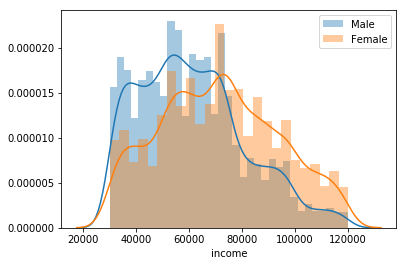

In [62]:
## Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

Male population outnumbers female population in lower and average income zone, while female population outnumbers the male population in higher income zone. 

In [63]:
profile[profile.gender=='M'].income.describe()

count      8484.000000
mean      61194.601603
std       20069.517615
min       30000.000000
25%       45000.000000
50%       59000.000000
75%       73000.000000
max      120000.000000
Name: income, dtype: float64

In [64]:
profile[profile.gender=='F'].income.describe()

count      6129.000000
mean      71306.412139
std       22338.353773
min       30000.000000
25%       54000.000000
50%       71000.000000
75%       88000.000000
max      120000.000000
Name: income, dtype: float64

In [65]:
profile[profile.gender=='O'].income.describe()

count       212.000000
mean      63287.735849
std       18938.594726
min       30000.000000
25%       51000.000000
50%       62000.000000
75%       79250.000000
max      100000.000000
Name: income, dtype: float64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

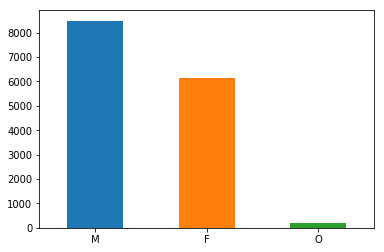

In [66]:
(profile['gender'].value_counts()).plot(kind='bar')
plt.xticks(rotation=0)

When considering the gender, the dataset is a little bit biased, as number of male population outnumbers the female population and there is small number of people for the other category. Speaking with the exact figures; there are 8484 males, 6129 females and only 212 others in the dataset.

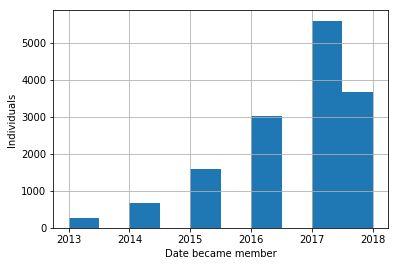

In [67]:
g = profile.year_joined.hist();
g.set_xlabel("Date became member");
g.set_ylabel("Individuals");

It is seen that the number of people who joins the program has an increase trend between the years of 2013 and 2017 with 2017 is the best year. 

#### 2.2.Highligths and Observations
* There are 17000 rows and 5 cloumns in the profile dataset.
* **id** and **gender** have object data type whereas **age, became_memeber_on** and **income** columns are numerical
* There are 2175 rows where the **gender** and **income**  are both null at the same time. **age** value is 118 on these rows. These rows are removed from dataset.
* **became_member_on** column transformed from string to date
* There is no duplicate row in the dataset
#####  Observations
* Minimum age for joining the reward program is 18. The mean of the **age** column is 55 and the distribution is similar to gaussion distribution which is an expected distribution.
* Minimum income is 30K and the income distribution is skewed to right as expected.
* Male population outnumbers female population in lower and average income zone, while female population outnumbers the male population in higher income zone. 
* When considering the **gender**, the dataset is a little bit biased, as number of male population outnumbers the female population and there is small number of people for the other category. Speaking with the exact figures; there are 8484 males, 6129 females and only 212 others in the dataset.
* It is seen that the number of people who joins the program has an increase trend between the years of 2013 and 2017 with 2017 is the best year. 

### 3.Transcript Dataset

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

#### 3.1.Data Exploration (Transcript Dataset)


In [68]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [69]:
transcript.shape

(306534, 4)

There are 306534 rows and 4 columns in the transcript dataset.

In [70]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**event, person** and **value** columns are object type, whereas the **time** column is integer.

In [71]:
# Rename person column to customer_id (identical than portfolio dataset to make the join later)
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [72]:
transcript.isnull().sum()

event          0
customer_id    0
time           0
value          0
dtype: int64

There is no null/missing column in the dataset

In [73]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [74]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


It is no suprise that **transaction** > **offer received** > **offer viewed** > **offer completed**

In [75]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
value          306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [76]:
transcript.customer_id.unique().shape

(17000,)

It seems that the people I removed from the profile dataset (rows with age == 118 and the gender&income columns missing) also included in the transcript dataset. Let's do further investigation.

In [77]:
unique_persons_in_transcript = transcript.customer_id .unique()
unique_persons_in_profile = profile.customer_id.values
id_of_persons_who_are_not_in_profile = [customer_id for customer_id  in unique_persons_in_transcript if not(customer_id  in unique_persons_in_profile)]

In [78]:
print(len(id_of_persons_who_are_not_in_profile))

2175


2175 is the exact same number of rows we removed from profile dataset. Let's remove these rows from the transcript dataset as well.

transcript = transcript.loc[transcript.person.isin(unique_persons_in_profile), :]

In [79]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [80]:
transcript.shape

(272762, 4)

In [81]:
len(transcript.customer_id.unique())

14825

In [82]:
# checking the current columns' datatypes 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 4 columns):
event          272762 non-null object
customer_id    272762 non-null object
time           272762 non-null int64
value          272762 non-null object
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [83]:
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


Let's expand the **value** column

In [84]:
# Extract each key that exist in 'value' column to a seperate column.
# getting the different keys  that exists in the 'value' column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

In [236]:
# checking the different keys of the 'value' dictionary
keys

['offer id', 'amount', 'offer_id', 'reward']

In [237]:
#create columns and specify the datatype of each of them
transcript['offer_id'] = '' # datatype : string
transcript['amount'] = 0.00  # datatype : integer
transcript['reward'] = 0  # datatype : integer

In [238]:
# Iterating over clean_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing 
            transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward'] = row['value'][k]

In [239]:
transcript['amount'].value_counts()[0]

148805

In [240]:
# change amount column type to float
transcript.time.astype('float')

# Parse time column: hours to days
transcript['time_in_days'] = (transcript['time'] / 24.0)

In [241]:
transcript.head()

,event,customer_id,time,value,offer_id,amount,reward,time_in_days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0.0,0,0.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,0.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0.0,0,0.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,0.0


In [242]:
transcript.shape

(272762, 8)

In [243]:
transcript.isnull().sum()

event           0
customer_id     0
time            0
value           0
offer_id        0
amount          0
reward          0
time_in_days    0
dtype: int64

In [244]:
# Extract transcript dataset rows when they are offer xxxxx in event column
offer_tr = transcript[transcript.event != 'transaction'].copy()
offer_tr.drop(['amount'], axis=1, inplace=True)

In [245]:
# One-hot encoding for event categorical feature 
offer_tr = pd.concat([offer_tr, pd.get_dummies(offer_tr.event)], axis=1)

In [246]:
offer_tr.head()

,event,customer_id,time,value,offer_id,reward,time_in_days,offer completed,offer received,offer viewed
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0,0,1,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0.0,0,1,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,0,1,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0,0.0,0,1,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0,0,1,0


In [247]:
offer_tr.shape

(148805, 10)

In [248]:
# Extract transcript rows when event is a transaction
transaction_tr = transcript[transcript.event == 'transaction'].copy()

# Then drop offer_id column (this column belongs to event = offer xxxxx)
transaction_tr.drop(['offer_id'], axis=1, inplace=True)

In [249]:
# Shor transaction_tr dataset
transaction_tr.head()

,event,customer_id,time,value,amount,reward,time_in_days
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83,0,0.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},34.56,0,0.0
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},13.23,0,0.0
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},19.51,0,0.0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},18.97,0,0.0


In [250]:
# Merge profile and offer_tr_cl on customer_id column
offer_profile = pd.merge(profile, offer_tr, on='customer_id', how='inner')

In [251]:
# Show the merged dataset
offer_profile.head()

,age,became_member_on,gender,customer_id,income,gender_F,gender_M,gender_O,age_group,income_range,...,member_type,event,time,value,offer_id,reward,time_in_days,offer completed,offer received,offer viewed
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,...,1,offer received,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,17.00,0,1,0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,...,1,offer received,504,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0,21.00,0,1,0
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,...,1,offer completed,528,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,22.00,1,0,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1,0,0,4,3,...,1,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00,0,1,0
4,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1,0,0,4,3,...,1,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.25,0,0,1


In [252]:
# Merge profile and transaction_tr on customer_id column
transaction_profile = pd.merge(profile, transaction_tr, on='customer_id', how='inner')

In [253]:
# Show transaction_profile merged dataset
transaction_profile.head()

,age,became_member_on,gender,customer_id,income,gender_F,gender_M,gender_O,age_group,income_range,gender_group,year_joined,membership_days,member_type,event,time,value,amount,reward,time_in_days
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,1,2017,641,1,transaction,18,{'amount': 21.51},21.51,0,0.75
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,1,2017,641,1,transaction,144,{'amount': 32.28},32.28,0,6.00
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1,0,0,3,3,1,2017,641,1,transaction,528,{'amount': 23.22},23.22,0,22.00
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1,0,0,4,3,1,2017,708,1,transaction,132,{'amount': 19.89},19.89,0,5.50
4,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1,0,0,4,3,1,2017,708,1,transaction,144,{'amount': 17.78},17.78,0,6.00


In [255]:
# Support function. Get the target feature: successful offer
def get_offer_succesful(offer_completed_data_df, offer_viewed_data_df, start_time, end_time):
    
    # get completed offers within end date
    offer_completed_withintime = np.logical_and(
    offer_completed_data_df['time_in_days'] >= start_time, offer_completed_data_df['time_in_days'] <= end_time)
            
    # get viewed offers within end date
    offer_viewed_withintime = np.logical_and(
    offer_viewed_data_df['time_in_days'] >= start_time, offer_viewed_data_df['time_in_days'] <=end_time)

    # offer successful is boolean (1/0): offer_successful is 1 if an offer is viewed and completed within end time, else to 0
    offer_successful = offer_completed_withintime.sum() > 0 and offer_viewed_withintime.sum() > 0
            
    # return the target feature
    return offer_successful

In [256]:
# Support function. Get the customer transaction data
def get_customer_transaction_data(customer_transaction_data_df, start_time, end_time):
    
    # extract transactions occured within time
    transaction_withintime = np.logical_and(
    customer_transaction_data_df['time_in_days'] >= start_time, customer_transaction_data_df['time_in_days'] <= end_time)
        
    transaction_data = customer_transaction_data_df[transaction_withintime]
    
    return transaction_data

In [257]:
# Support function. Get the combined data rows to dictionary
def get_rows(rows, row, offer_row, customer):
                  
    row.update(offer_row.iloc[0,0:].to_dict())
    row.update(customer.iloc[0,:].to_dict())
    rows.append(row)
            
    return rows

In [258]:

# Main function. Get the combined data between offers, transactions and customers.
def get_data_combined_df(profile, portfolio, offer_profile, transaction_profile):
    '''
    INPUT 
        profile - original profile dataset
        portfolio - original portfolio dataset
        offer_profile - offer_profile dataset
        transaction_profile - transaction_profile dataset
        
    OUTPUT
        Return a combined dataset with the most interesting features to build classification models
    '''
    data_combined = []
    customer_ids = offer_profile['customer_id'].unique()
    
    # loop through all customer ids in offer received dataset
    for ind in range(len(customer_ids)):
    
        # get customer
        customer_id = customer_ids[ind]
        
        # get customer from profile dataset
        customer = profile[profile['customer_id']==customer_id]
        
        # get customer_offer_data from offer_profile dataset
        customer_offer_data = offer_profile[offer_profile['customer_id']==customer_id]
        
        # get customer_transaction_data from transaction_profile dataset
        customer_transaction_data = transaction_profile[transaction_profile['customer_id']==customer_id]
        
        # get received, completed and viewed offer data from customer_offer_data dataset
        offer_received_data = customer_offer_data[customer_offer_data['offer received'] == 1]
        offer_completed_data = customer_offer_data[customer_offer_data['offer completed'] == 1]
        offer_viewed_data = customer_offer_data[customer_offer_data['offer viewed'] == 1]
        
        empty_rows = []
        
        # loop for offer receiveds
        for i in range(offer_received_data.shape[0]):
            
            # get offer id from offer_received_data dataset
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # get offer row from portfolio datset
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # set up start and end time from offer_received_data dataset
            start_time = offer_received_data.iloc[i]['time_in_days']
            end_time = start_time + duration_days
           
            # get offer_successful
            offer_successful = get_offer_succesful(offer_completed_data, offer_viewed_data, start_time, end_time)
            
            # get transaction data
            transaction_data = get_customer_transaction_data(customer_transaction_data, start_time, end_time)
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': customer_id,
                'time_in_days': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            rows = get_rows(empty_rows, row, offer_row, customer)
        
        data_combined.extend(rows)
    
    return pd.DataFrame(data_combined)

In [259]:
# get data combined dataset
import time
data_combined_df = get_data_combined_df(profile, portfolio, offer_profile, transaction_profile)

In [260]:
data_combined_df.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

In [261]:
# data combined info 
data_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 30 columns):
age                 66501 non-null int64
age_group           66501 non-null int64
became_member_on    66501 non-null datetime64[ns]
bogo                66501 non-null int64
channels            66501 non-null object
customer_id         66501 non-null object
difficulty          66501 non-null int64
discount            66501 non-null int64
duration            66501 non-null int64
email               66501 non-null int64
gender              66501 non-null object
gender_F            66501 non-null int64
gender_M            66501 non-null int64
gender_O            66501 non-null int64
gender_group        66501 non-null int64
income              66501 non-null int64
income_range        66501 non-null int64
informational       66501 non-null int64
member_type         66501 non-null int64
membership_days     66501 non-null int64
mobile              66501 non-null int64
offer_id          

In [262]:
data_combined_df.to_csv('data/combined_data.csv', index=False)

In [2]:
# load datasets
combined_data = pd.read_csv('data/combined_data.csv')
portfolio_cleaned = pd.read_csv('data/portfolio.csv')


In [7]:
def calculate_test_and_train(features, target, test_size, scaler = False):
    '''
    INPUT 
        features - features dataset
        target - target / class feature dataset
        test_size - split test size percentage
        scaler - if True applies MinMaxScaler function. False by default
        
    OUTPUT
        Returns train and test splits
    '''
    X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=test_size, random_state=42)
    
    if (scaler):
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)

    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

In [8]:
def build_model(algorithm, grid_params, scorer, X_train, y_train):
    '''
    Apply RandomizedSearchCV and build the model algorithm with the passed parameters.
    
    INPUT 
        algorithm - algorithm used to create a model
        grid_params - set of grid params
        scorer - scorer
        X_train - train matrix of features
        y_train - train array of the class feature
        
    OUTPUT
        Return the fitted model
    '''
    lr_random = RandomizedSearchCV(
        estimator = algorithm, 
        
        param_distributions = grid_params, 
        scoring=scorer, 
        n_iter = 12, 
        cv = 3, 
        verbose=2, 
        random_state=42, 
        n_jobs = 3)

    lr_random.fit(X_train, y_train)
    
    return lr_random

In [9]:
# Support function get class classifier name
def get_class_name(clf):
    
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]
    
    return class_name

In [10]:
# Calculate and show model metrics on demand
def show_model_metrics(clf, X_test, y_test, full_outcome = True):
    '''
    Show the main metrics of the model
    
    INPUT 
        clf - classifier model 
        X_test - test features matrix
        y_test - test target feature array
        full_outcome - if True returns the full metrics outcome
    OUTPUT
        Return model metrics
    '''
    class_name = get_class_name(clf)

    y_pred_rf = clf.predict(X_test)

    clf_accuracy = accuracy_score(y_test, y_pred_rf)
    clf_f1_score = f1_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf)
    recall = recall_score(y_test, y_pred_rf)
    
    if( full_outcome == True):
        print("%s accuracy: %.3f" % (class_name, clf_accuracy))
        print("%s f1-score: %.3f" % (class_name, clf_f1_score))
        print("%s precision: %.3f" % (class_name, precision))
        print("%s recall: %.3f" % (class_name, recall))

        sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap='Blues', square=True)
        plt.show()
    
    return clf_accuracy, clf_f1_score, y_pred_rf

In [11]:
# Calculate AUC-ROC curve and show a visualization
def show_roc_auc(algorithm_name, y_test, predicted):
    '''
    Display the ROC visualization
    
    INPUT 
        clf - classifier model 
        X_test - test features matrix
        predicted - targets predicted by the clf
        
    OUTPUT
        ROC plot visualization
    '''
    
    fpr, tpr, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(fpr, tpr)
    performance_auc[algorithm_name] = roc_auc

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
performance_auc = {}
scorer = make_scorer(fbeta_score, beta=0.5)

In [18]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 19 columns):
age_group           66501 non-null int64
bogo                66501 non-null int64
channels            66501 non-null object
difficulty          66501 non-null int64
discount            66501 non-null int64
email               66501 non-null int64
gender_F            66501 non-null int64
gender_M            66501 non-null int64
gender_O            66501 non-null int64
gender_group        66501 non-null int64
income_range        66501 non-null int64
informational       66501 non-null int64
member_type         66501 non-null int64
mobile              66501 non-null int64
offer_successful    66501 non-null int64
offer_type          66501 non-null object
reward              66501 non-null int64
social              66501 non-null int64
web                 66501 non-null int64
dtypes: int64(17), object(2)
memory usage: 9.6+ MB


In [19]:
combined_data.drop(columns=['channels', 'offer_type'], inplace=True)
combined_data.drop(columns=['channels', 'offer_type','customer_id', 'offer_id', 'total_amount', 'age', 'became_member_on', 'duration', 'gender', 'income', 'membership_days', 'year_joined', 'time_in_days'], inplace=True)


In [21]:
# Prepare features and target
class_label_name = 'offer_successful'

split_val =  0.3

features = combined_data.drop(columns=[class_label_name])
target = combined_data.filter([class_label_name])

# get test and train 
X_train, X_test, y_train, y_test = calculate_test_and_train(features, target, split_val)

In [22]:
# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# instantiate a logistic regression classifer object
log_reg = LogisticRegression(random_state=42, solver='liblinear')

# Build the logistic regression model
log_reg_random = build_model(log_reg, grid_params, scorer, X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] penalty=l2, C=10 ................................................
[CV] penalty=l2, C=10 ................................................
[CV] penalty=l2, C=10 ................................................
[CV] ................................. penalty=l2, C=10, total=   1.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................................. penalty=l2, C=10, total=   1.1s
[CV] penalty=l2, C=100 ...............................................
[CV] ................................. penalty=l2, C=10, total=   1.3s
[CV] penalty=l2, C=100 ...............................................
[CV] ................................ penalty=l2, C=100, total=   0.9s
[CV] ................................ penalty=l2, C=100, total=   0.7s
[CV] penalty=l1, C=0.001 .............................................
[CV] penalty=l1, C=0.001 .............................................
[CV] ...........

[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:   43.4s finished


In [23]:
log_reg_random.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression model accuracy: 0.693
LogisticRegression model f1-score: 0.694
LogisticRegression model precision: 0.657
LogisticRegression model recall: 0.735


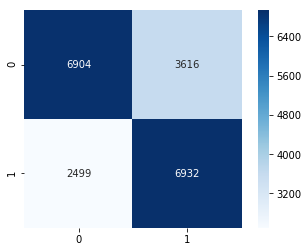

In [25]:
# evaluate logistic regression model's performance
import re
x, y, pred_lr = show_model_metrics(log_reg_random.best_estimator_, X_test, y_test)

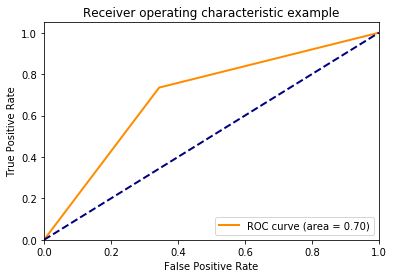

In [26]:
# Call function to display ROC visualization
show_roc_auc('LogisticRegression', y_test, pred_lr)

In [27]:
# instantiate the classifier object
gb_clf = GradientBoostingClassifier()

# Minimum number of samples required to split a node
min_split_samples = [2, 5, 8, 11]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]

# Create the random grid
gb_random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300, 350],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_split_samples}

In [28]:
# Call function to build the model
gboost_random = build_model(gb_clf, gb_random_grid, scorer, X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_estimators=10, min_samples_split=11, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV] n_estimators=10, min_samples_split=11, min_samples_leaf=2, loss=deviance, learning_rate=0.01 
[CV] n_estimators=10, min_samples_split=11, min_samples_leaf=2, loss=deviance, learning_rate=0.01 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=11, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   0.8s
[CV]  n_estimators=10, min_samples_split=11, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   0.9s
[CV] n_estimators=350, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=10, min_samples_split=11, min_samples_leaf=2, loss=deviance, learning_rate=0.01, total=   0.9s
[CV] n_estimators=350, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.01 
[CV] n_estimators=350, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=350, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.01, total=  23.3s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=350, min_samples_split=2, min_samples_leaf=1, loss=exponential, learning_rate=0.01, total=  23.4s
[CV] n_estimators=5

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   3.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.01 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   3.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.01 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, loss=deviance, learning_rate=0.001, total=   3.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.01, total=   6.4s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.01, total=   6.4s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, loss=exponential, learning_rate=0.01, total=   6.4s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001, total=  19.5s
[CV] n

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   2.6s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   2.8s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=30, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   2.9s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   6.8s
[CV] n_estimators=10, min_samples_split=11, min_samples_leaf=8, loss=exponential, learning_rate=0.001 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   6.9s
[CV] n_estimators=10, min_samples_split=11, min_samples_leaf=8, loss=exponential, learning_rate=0.001 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=11, min_samples_leaf=8, loss=exponential, learning_rate=0.001, total=   0.9s
[CV] n_estimators=10, min_samples_split=11, min_samples_leaf=8, loss=exponential, learning_rate=0.001 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=4, loss=exponential, learning_rate=0.001, total=   6.8s
[CV]  n_estimators=10, min_samples_split=11, min_samples_leaf=8, loss=exponential, learning_rate=0.001, total=   0.7s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=1, loss=exponential, learning_rate=0.001 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=10, min_samples_split=11, min_samples_leaf=8, loss=exponential, learning_rate=0.001, total=   0.8s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=1, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=  13.5s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=  13.4s
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=1, loss=exponential, learning_rate=0.001, total=  13.7s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001 
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=8, loss=exponential, learning_rate=0.001, total=   9.0

[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  1.9min finished


In [29]:
# Show the best model estimator
gboost_random.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=350,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier model accuracy: 0.703
GradientBoostingClassifier model f1-score: 0.710
GradientBoostingClassifier model precision: 0.659
GradientBoostingClassifier model recall: 0.771


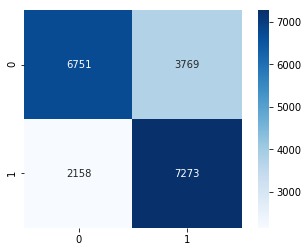

In [30]:
# evaluate random forest classifier model's performance
x, y, pred_gb = show_model_metrics(gboost_random.best_estimator_, X_test, y_test)

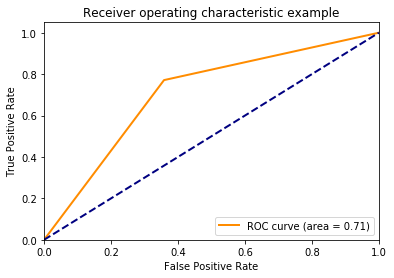

In [31]:
# Call function to display ROC visualization
show_roc_auc('GradientBoosting', y_test, pred_gb)

In [32]:
# instantiate a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300, 350, 500, 1000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 13)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_split_samples = [2, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_split_samples,
               'min_samples_leaf': min_samples_leaf}

In [33]:
# Call function to build the model
rf_random = build_model(rf_clf, random_grid_params, scorer, X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=  18.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=  18.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=  18.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11 
[CV]  n_estimators=1000,

[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  4.2min finished


In [34]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 9}

RandomForestClassifier model accuracy: 0.704
RandomForestClassifier model f1-score: 0.707
RandomForestClassifier model precision: 0.665
RandomForestClassifier model recall: 0.755


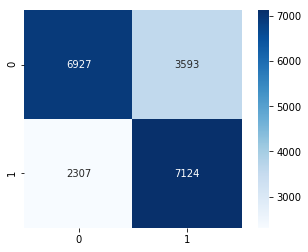

In [36]:
# evaluate random forest classifier model's performance
x, y, pred_rf = show_model_metrics(rf_random.best_estimator_, X_test, y_test)

In [37]:
# Calculate the best features according to importance on RandomForest classifier
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(features,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

Text(0.5,1,'Random Forest Estimated Feature Importance')

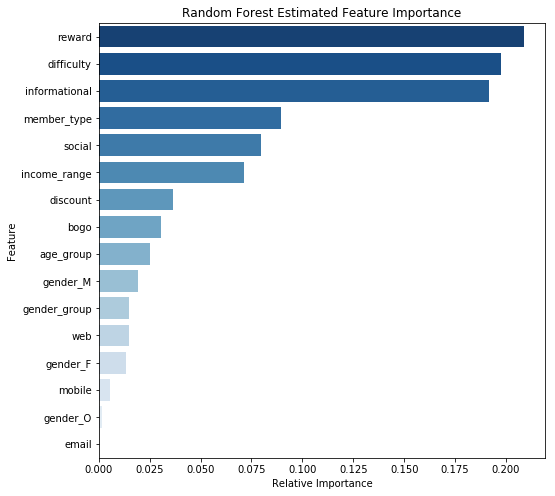

In [38]:
# Show estimated feature importance plot
plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')